In [1]:
import sys
sys.path.append('..')
from src.models.pipeline import pipeline
import glob
import json
import os
import pandas as pd
import ast
from datetime import datetime
from src.models.train_model import functionsBuilder
from src.models.audio import downloadAudioFromYoutube
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from src.data import pdf
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from src.visualization.visualize import MyPlotting
from gensim import similarities
import re
import statistics
import numpy as np

In [2]:
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''

def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec


for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])

In [3]:
df_results = pd.read_csv('../data/processed/bayesian_opt/results.csv')
#best_results = df_results.groupby('video')[['video','workflow','params','max_target']].max().values.tolist()
n_largest_res = 1
'''This is the videos that have a pdf'''
filtered_video = ['x5zLaWT5KPs','dkAr9ThdSUU','2mC1uqwEmWQ']
best_results = df_results[df_results['video'].isin(filtered_video)].groupby('video')[['video','workflow','params','max_target']].apply(lambda grp: grp.nlargest(n_largest_res,'max_target')).values.tolist()


In [4]:
filtered_video = [bs[0] for bs in  best_results]
best_results

[['2mC1uqwEmWQ',
  'sliding_window-tfidf-cosine-None-spectral_clustering',
  "{'n_clusters': 18.0, 'sim_thresh': 0.6, 'step_size': 60.0, 'window_size': 150.0}",
  0.666666667],
 ['dkAr9ThdSUU',
  'sliding_window-tfidf-cosine-None-spectral_clustering',
  "{'n_clusters': 14.786160659898577, 'sim_thresh': 0.5924873369457966, 'step_size': 10.073958555862824, 'window_size': 60.422260605496106}",
  0.529411765],
 ['x5zLaWT5KPs',
  'sliding_window-tfidf-cosine-median_(2,2)-spectral_clustering',
  "{'n_clusters': 16.337584170265377, 'sim_thresh': 0.41809582990182614, 'step_size': 10.755820215830166, 'window_size': 59.001060125386914}",
  0.8571428571428571]]

In [5]:
vid_words= []
vids_shift_times = []
vids_id = []
#best_results = best_results[1:]
for vid_results in best_results: #range(0,len(best_results),n_largest_res):
    '''From the get optimized by bayesian we get that for the video '''
    # the precision is about 66% 
    vid = vid_results[0]
    params = ast.literal_eval(vid_results[2]) #{'n_clusters': 18, 'sim_thresh': 0.6, 'step_size': 49, 'window_size': 150}
    #print(params)
    for key in ['n_clusters','step_size','window_size']:
        params[key] = int(params[key])# - 1
    workflow = vid_results[1] #'sliding_window-tfidf-cosine-median_(3,3)-spectral_clustering'

    groundbase = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()[:-1]
    transcripts = transcripts_jsons[vid]
    #print(grounbase)
    _pipeline = workflow.split('-')
    filter_type = None
    mask_shape = None
    filtering = _pipeline[3]
    if filtering != 'None':
        filter_type = filtering.split('_')[0]
        mask_shape = ast.literal_eval(filtering.split('_')[1])
    '''This running may not work at first time do not give up and run it couple of times'''

    '''print('Running the following %s for video %s with params %s %s %s'
          %(workflow, vid,params,filter_type,mask_shape))'''
    shift_times,topic_words = (None,None)
    while shift_times is None and topic_words is None:
        shift_times,topic_words = pipeline.run_for_baye(groundbase,transcripts,slicing_method='sliding_window',
                              window_size=params['window_size'],step_size_sd=params['step_size'],
                              #silence_threshold=-30,slice_length=1000,step_size_audio=10,wav_file_path="../../data/raw/audio/Mod-01 Lec-01 Foundation of Scientific Computing-01.wav",                
                              vector_method='tfidf',vectorizing_params=None,
                              similarity_method='cosine',
                              filter_params={"filter_type":filter_type,
                                             "mask_shape":mask_shape,
                                             "sim_thresh":params['sim_thresh'],
                                             "is_min_thresh":True
                                             },
                             clustering_params={
                                     'algorithm':'spectral_clustering',
                                     'n_clusters':params['n_clusters']
                                     },return_value='division') or (None,None)
    print("For video %s, %s where found" %(vid,len(shift_times)))
    vid_words.append(topic_words)
    vids_shift_times.append(shift_times)
    vids_id.append(vid)

For video 2mC1uqwEmWQ, 10 where found
For video dkAr9ThdSUU, 9 where found
For video x5zLaWT5KPs, 8 where found


In [6]:
print(len(vid_words[0]))


11

In [7]:
def find_top_words_of_topic(topic_words):
    for tp_i,tp_words in enumerate(topic_words):
        print('Finding top words for topic %s' %(tp_i))
        raw_text = ' '.join(tp_words)
        myvectorizer = CountVectorizer()
        mytf = myvectorizer.fit_transform([raw_text]).toarray()
        #print(mytf)
        maxes = heapq.nlargest(4,mytf[0])
        indexes = []
        for i,bal in enumerate(mytf[0]):
            if bal in maxes:
                indexes.append(i)
        [ print(myvectorizer.get_feature_names()[_]) for i,_ in enumerate(indexes)]
        
#find_top_words_of_topic(vid_words[0])

##############   2mC1uqwEmWQ   #############


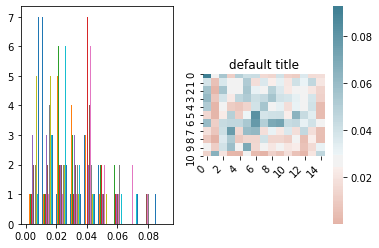

15
11
topic 1,correlated chapter is 1. Introduction
topic 2,correlated chapter is 2.4. General Search for Itemsets and Search for Rules
topic 3,correlated chapter is 1. Introduction
topic 4,correlated chapter is 1. Introduction
topic 5,correlated chapter is 3.2. The algorithm
topic 6,correlated chapter is 3. The Apriori Algorithm
topic 7,correlated chapter is 3. The Apriori Algorithm
topic 8,correlated chapter is 2.2. The Size of Itemsets
topic 9,correlated chapter is 2.2. The Size of Itemsets
topic 10,correlated chapter is 2.4. General Search for Itemsets and Search for Rules
topic 11,correlated chapter is 2. Itemsets and Associations
##############   dkAr9ThdSUU   #############


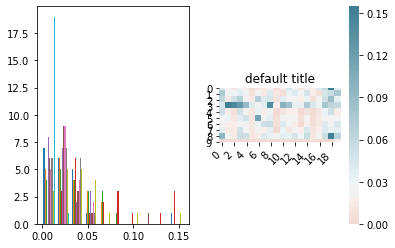

20
10
topic 1,correlated chapter is 3.13 Information Theory
topic 2,correlated chapter is 3.14 Structured Probabilistic Models
topic 3,correlated chapter is 3.13 Information Theory
topic 4,correlated chapter is 3.2 Random Variables
topic 5,correlated chapter is 3.13 Information Theory
topic 6,correlated chapter is 3.5 Conditional Probability
topic 7,correlated chapter is 3.7 Independence and Conditional Independence
topic 8,correlated chapter is 3.3.1 Discrete Variables and Probability Mass Functions
topic 9,correlated chapter is 3.13 Information Theory
topic 10,correlated chapter is 3.14 Structured Probabilistic Models
##############   x5zLaWT5KPs   #############


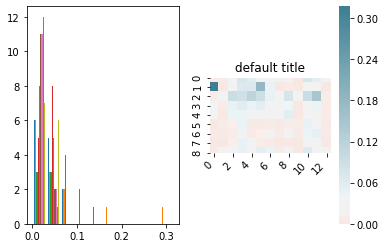

13
9
topic 1,correlated chapter is 1.4.1 Subjective selection
topic 2,correlated chapter is 1.2.2 Kernels
topic 3,correlated chapter is 1.4.2 Selection with reference to some given distribution
topic 4,correlated chapter is 1.2 Kernel density estimation
topic 5,correlated chapter is 1.3.4 Optimal kernels
topic 6,correlated chapter is 1.4.1 Subjective selection
topic 7,correlated chapter is 1.4.2 Selection with reference to some given distribution
topic 8,correlated chapter is 1.2 Kernel density estimation
topic 9,correlated chapter is 1.4.1 Subjective selection


In [8]:
for vid_index,filt_vid in enumerate(filtered_video):
    print('##############   %s   #############' %(filt_vid))
    
    pdf_file = glob.glob('../data/raw/pdf/' + filt_vid + '/*')[0]
    pdf_raw_text = pdf.read_pdf_raw(pdf_file)
    chapter_titles,start_end_indexes = pdf.get_chapters_titles(pdf_raw_text)
    chapters_content = pdf.get_chapters_content(pdf_raw_text,start_end_indexes)
    #print(chapter_titles)
    #print(chapters_content[0])
    # let's create a dictionary of the whole of the words in the paper and the video

    # adding the video words
    raw_text_all = []
    for tp_vid in vid_words[vid_index]:
        raw_text_all = raw_text_all + tp_vid

    #len(raw_text_all)    

    paper_chapters_one_doc = []
    for index,chapter in enumerate(chapters_content):
        x = reduce(lambda x,y: x+y,chapter,[])
        paper_chapters_one_doc.append(x)
        raw_text_all = raw_text_all + x
    #len(raw_text_all)    

    #raw_text_all
    # creating dictionary of all of the words in the corpus of the video and the paper
    dictionary = Dictionary([raw_text_all])
    #dictionary.doc2bow(raw_text_all[0:30])
    
    whole_corpus = vid_words[vid_index] + paper_chapters_one_doc
    #print(len(paper_chapters_one_doc))
    #print(len(topic_words))
    #print(len(whole_corpus))

    """maybe think in the future to apply different model 
    rather than tfidf or calculate the document differntly"""
    #print(whole_corpus)
    bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
    tf_idf_model = models.TfidfModel(bgw_corpus)
    #print(tf_idf_model[bgw_corpus[0]])
    bgw_chapter = [dictionary.doc2bow(doc) for doc in paper_chapters_one_doc]
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model[bgw_chapter],
                                                    num_features=len(dictionary))
    bgw_vids = [dictionary.doc2bow(doc) for doc in vid_words[vid_index]]
    
    correlation = [[s for s in index_sim[tf_idf_model[doc]]] for doc in bgw_vids]
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] )
    #corr_as_row = list(np.array([list(corr_r) for corr_r in correlation]).reshape(-1,1))
    #print(corr_as_row)
    MyPlotting.similarity_matrix(correlation,min_=min(corr_as_row),
                                 center=statistics.median(corr_as_row),
                                 max_=max(corr_as_row))
    print(len(correlation[0]))
    print(len(correlation))
    for i,corr in enumerate(correlation):
        max_cor = max(corr)
        """print ("topic %s, topic ends at %s ,correlated chapter is %s" 
               %(i+1,vids_shift_times[vid_index][i], chapter_titles[corr.index(max_cor)]))"""
        print ("topic %s,correlated chapter is %s" 
               %(i+1, chapter_titles[corr.index(max_cor)]))
    

In [12]:
chapter_titles

[' Why Probability?',
 ' Random Variables',
 ' Probability Distributions',
 ' Discrete Variables and Probability Mass Functions',
 ' Continuous Variables and Probability Density Functions',
 ' Marginal Probability',
 ' Conditional Probability',
 ' The Chain Rule of Conditional Probabilities',
 ' Independence and Conditional Independence',
 ' Common Probability Distributions',
 ' Bernoulli Distribution',
 ' Multinoulli Distribution',
 ' Gaussian Distribution',
 ' Exponential and Laplace Distributions',
 ' The Dirac Distribution and Empirical Distribution',
 ' Mixtures of Distributions',
 ' Useful Properties of Common Functions',
 ' Technical Details of Continuous Variables',
 ' Information Theory',
 ' Structured Probabilistic Models']

In [23]:
chapters_content[0]

[['many',
  'branch',
  'computer',
  'science',
  'deal',
  'entity',
  'deterministic',
  'certain'],
 ['assume', 'execute', 'machine', 'instruction'],
 ['error',
  'hardware',
  'occur',
  'rare',
  'enough',
  'software',
  'application',
  'need',
  'design',
  'account'],
 ['give',
  'many',
  'computer',
  'scientist',
  'software',
  'engineer',
  'work',
  'clean',
  'certain',
  'environment',
  'surprising',
  'machine',
  'learning',
  'make',
  'heavy',
  'use',
  'probability',
  'theory'],
 ['machine',
  'must',
  'deal',
  'uncertain',
  'quantity',
  'may',
  'need',
  'deal',
  'stochastic',
  'non',
  'deterministic',
  'quantity'],
 ['uncertainty', 'stochasticity', 'arise', 'many', 'source'],
 ['researcher',
  'make',
  'compelling',
  'argument',
  'quantify',
  'uncertainty',
  'use',
  'probability',
  'least'],
 ['many', 'argument', 'present', 'summarize', 'inspired', 'pearl'],
 ['activity', 'require', 'ability', 'reason', 'presence', 'uncertainty'],
 ['fact',
 

In [19]:
topic_words[0]

['today',
 'class',
 'probability',
 'information',
 'theory',
 'important',
 'study',
 'huge',
 'field',
 'today',
 'shall',
 'try',
 'concentrate',
 'basic',
 'principle',
 'necessary',
 'understand',
 'design',
 'analysis',
 'cipher',
 'today',
 'talk',
 'shall',
 'talk',
 'importance',
 'probability',
 'cryptography',
 'discuss',
 'computational',
 'security',
 'follow',
 'discussion',
 'distribution',
 'application',
 'important',
 'birthday',
 'paradox',
 'conclude',
 'concept',
 'entropy',
 'information',
 'theory',
 'discuss',
 'remember',
 'first',
 'class',
 'try',
 'answer',
 'question',
 'nature',
 'probable',
 'insecure',
 'event',
 'remember',
 'example',
 'coin',
 'flip',
 'telephone',
 'question',
 'probability',
 'create',
 'equal',
 'remember',
 'question',
 'alice',
 'able',
 'choose',
 'different',
 'value',
 'outcome',
 'denote',
 'question',
 'try',
 'address',
 'important',
 'information',
 'question',
 'value',
 'able',
 'extract',
 'information',
 'parity',
 't

In [36]:
# let's create a dictionary of the whole of the words in the paper and the video

# adding the video words
raw_text_all = []
for tp_vid in topic_words:
    raw_text_all = raw_text_all + tp_vid
    
len(raw_text_all)    
    
paper_chapters_one_doc = []
for index,chapter in enumerate(chapters_content):
    x = reduce(lambda x,y: x+y,chapter,[])
    paper_chapters_one_doc.append(x)
    raw_text_all = raw_text_all + x
len(raw_text_all)    

#raw_text_all
# creating dictionary of all of the words in the corpus of the video and the paper
dictionary = Dictionary([raw_text_all])
#dictionary.doc2bow(raw_text_all[0:30])

In [44]:
whole_corpus = topic_words + paper_chapters_one_doc
print(len(paper_chapters_one_doc))
print(len(topic_words))
print(len(whole_corpus))

"""maybe think in the future to apply different model 
rather than tfidf or calculate the document differntly"""
#print(whole_corpus)
bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
tf_idf_model = models.TfidfModel(bgw_corpus)
#print(tf_idf_model[bgw_corpus[0]])
bgw_chapter = [dictionary.doc2bow(doc) for doc in paper_chapters_one_doc]
index_sim = similarities.SparseMatrixSimilarity(tf_idf_model[bgw_chapter],
                                                num_features=len(dictionary))
bgw_vids = [dictionary.doc2bow(doc) for doc in topic_words]
correlation = [[s for s in index_sim[tf_idf_model[doc]]] for doc in bgw_vids]
MyPlotting.similarity_matrix(correlation)
for i,corr in enumerate(correlation):
    max_cor = max(corr)
    print ("For topic %s the most correlated chapter is %s with correlatoin ratio %s" 
           %(i+1,chapter_titles[corr.index(max_cor)],max_cor))

20
16
36


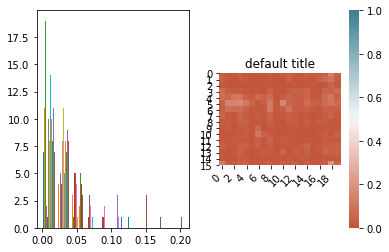

For topic 1 the most correlated chapter is  Information Theory with correlatoin ratio 0.1397547
For topic 2 the most correlated chapter is  Information Theory with correlatoin ratio 0.10312224
For topic 3 the most correlated chapter is  Information Theory with correlatoin ratio 0.048375133
For topic 4 the most correlated chapter is  Structured Probabilistic Models with correlatoin ratio 0.084179744
For topic 5 the most correlated chapter is  Information Theory with correlatoin ratio 0.11074835
For topic 6 the most correlated chapter is  Discrete Variables and Probability Mass Functions with correlatoin ratio 0.16641639
For topic 7 the most correlated chapter is  Independence and Conditional Independence with correlatoin ratio 0.12060974
For topic 8 the most correlated chapter is  Why Probability? with correlatoin ratio 0.057244457
For topic 9 the most correlated chapter is  Continuous Variables and Probability Density Functions with correlatoin ratio 0.04371377
For topic 10 the most co